# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится.

Постройте модель с максимально большим значением *accuracy*. Нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

### Цели и задачи проекта

**Цели:**

* Провести исследование с целью предложить пользователям новый тариф «Смарт» или «Ультра» на основании их поведения.

* Результаты исследования позволят специалистам выбрать самую качественную модель, которая выберет подходящий тариф.

**Задачи:**

* Откроем файл с данными и изучим его.
* Разделим исходные данные на обучающую, валидационную и тестовую выборки.
* Исследуем качество разных моделей, меняя гиперпараметры. Кратко напишем выводы исследования.
* Проверим качество модели на тестовой выборке.
* Дополнительное задание: проверим модели на вменяемость

### Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.
**Известно:**

* сalls — количество звонков,
* minutes — суммарная длительность звонков в минутах,
* messages — количество sms-сообщений,
* mb_used — израсходованный интернет-трафик в Мб,
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откройте и изучите файл

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
from sklearn.dummy import DummyClassifier

import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np








In [3]:
try:
    df = pd.read_csv(r'D:\data_set/users_behavior.csv', sep=',')
except:
    df = pd.read_csv('/datasets/users_behavior.csv', sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [3]:
df.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


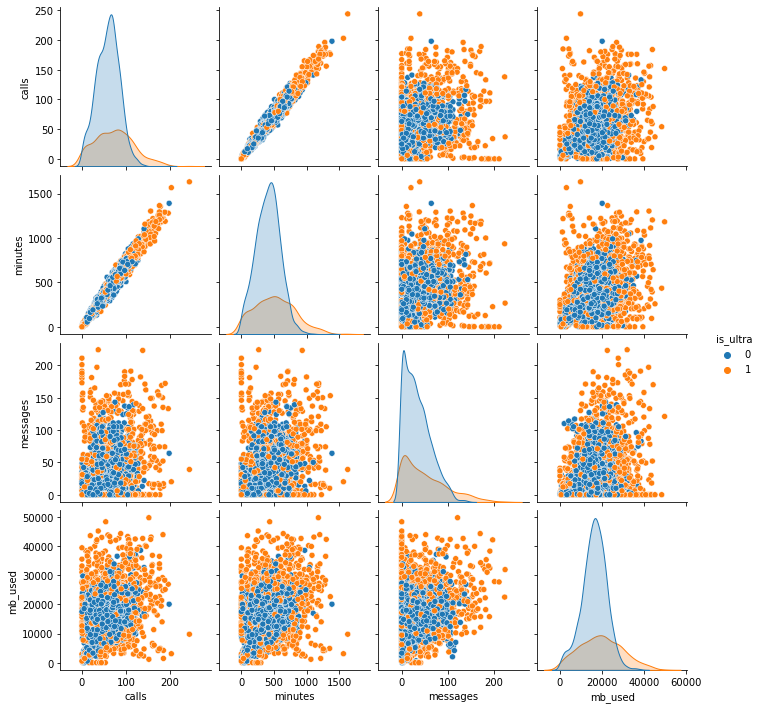

In [4]:
sns.pairplot(df, hue='is_ultra')

Из диаграмм разброса видно, что минуты и звонки сильно коррелируют друг с другом, что логично. Построим матрицу для большей наглядности:

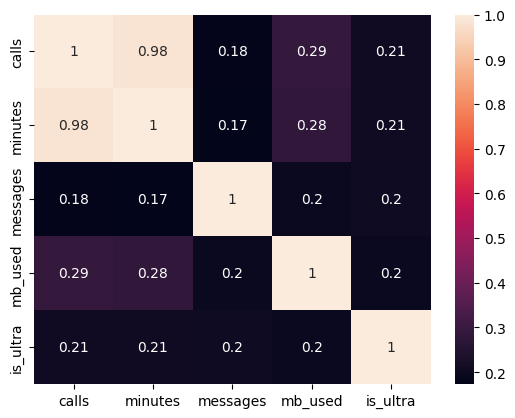

In [4]:
sns.heatmap(df.corr(), annot = True)
plt.show()

In [5]:
df_new = df.drop('calls', axis=1)

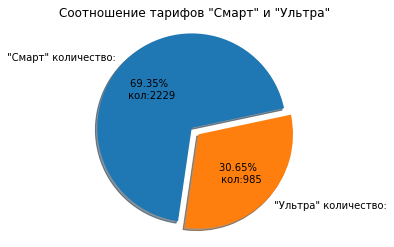

In [7]:
y = df_new['is_ultra'].value_counts()
fig1, ax1 =  plt.subplots()

#функия красиво вывести количество строк
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}% \n кол:{v:d}'.format(p=pct,v=val)
    return my_autopct
ax1.pie(y,
        autopct=make_autopct(y),
        shadow=True,
        labels=['"Смарт" количество:',
                '"Ультра" количество:'],
        startangle=12.,
       explode=(0.1,0))


ax1.axis('equal')  
plt.title('Соотношение тарифов "Смарт" и "Ультра"',fontsize=12)
plt.show()

Тарифов "Смарт" больше чем в два раза больше чем тарифов "Ультра"

## Разбейте данные на выборки

Мы должны подготовить два таких набора — один для проверки наших моделей во время их точной настройки, а еще один — в качестве окончательного датасета для сравнения моделей и выбора лучшей.Так же главная идея заключается в том, получает ли наш алгоритм равные возможности для изучения признаков каждого из представленных классов и последующего тестирования результатов обучения, на равном числе экземпляров каждого класса.Мы можем задать пропорцию классов при разделении на обучающий и проверяющий датасеты с помощью параметра stratify = df_new['is_ultra'] по тарифам. 

In [8]:
#разобьем на обучающую 
df_train, df_test_and_valid = train_test_split(
    df_new, test_size=0.30, random_state=12345, stratify=df_new['is_ultra'])

In [9]:
# на тестовую и валидационную 
df_test, df_valid = train_test_split(
    df_test_and_valid, test_size=0.5, random_state=12345, stratify=df_test_and_valid['is_ultra'])


In [10]:
#Для тренировочной 
features_train = df_train.drop('is_ultra', axis=1)
target_train = df_train['is_ultra']


In [11]:
#для тестовой 
features_test = df_test.drop('is_ultra', axis=1)
target_test = df_test['is_ultra']


In [12]:
#валидационная 
features_valid = df_valid.drop('is_ultra', axis=1)
target_valid = df_valid['is_ultra']

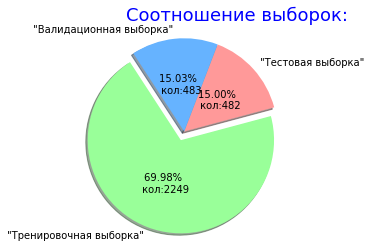

In [13]:

y = [df_test.shape[0],df_valid.shape[0],df_train.shape[0]]
fig1, ax1 =  plt.subplots()
colors = ['#ff9999','#66b3ff','#99ff99']
explode = (0, 0, 0.1)
ax1.pie(y,
        autopct=make_autopct(y),
        shadow=True,
        labels=['"Тестовая выборка"',#+str(df_test.shape[0]),
                '"Валидационная выборка"',#+str(df_valid.shape[0]),
               '"Тренировочная выборка"'],#+str(df_train.shape[0])],
                startangle = 15,
                pctdistance = 0.5,
                colors = colors,
                explode=explode)


ax1.axis('equal')  
plt.title('Соотношение выборок:',fontsize=18,loc='right',color='b')

plt.show()

## Исследуйте модели

### Дерево решений 

Начнем как в теории с дерева решений. Пока что единственный гипперпараметр который мы можем варьировать это глубина дерева. Поэтому пройдемся циклом от 1 до 10 по нему и выберем наилучшее значение accuracy для глубины дерева на вариационной выборке.

In [14]:
#лучшие параметры модели
best_tree_model = None
#лучшая глубина дерева
best_tree_depth = 0
#наилучшее знначение точности
best_accuracy = 0
#построить графики
accuracy_train_tree = []
accuracy_valid_tree = []
depth_list = []



for depth in range(2, 31):
    depth_list.append(depth)
    #создаем 
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    #обучаем
    model_tree.fit(features_train, target_train)
    #проверяем
    accuracy_train = model_tree.score(features_train, target_train) 
    accuracy_valid = model_tree.score(features_valid, target_valid)
    # добовляем значения 
    accuracy_train_tree.append(accuracy_train) 
    accuracy_valid_tree.append(accuracy_valid)
    # ищем лучшую 
    if accuracy_valid > best_accuracy:
        best_tree_model = model_tree
        best_tree_depth = depth
        best_accuracy = accuracy_valid
print('Лучшая модель дерева решений', best_tree_model)
print('Лучшая глубина дерева', best_tree_depth)
print('Accuracy лучшей модели', best_accuracy)       

Лучшая модель дерева решений DecisionTreeClassifier(max_depth=7, random_state=12345)
Лучшая глубина дерева 7
Accuracy лучшей модели 0.8012422360248447


In [15]:
accuracy_valid_tree[7]

0.8012422360248447

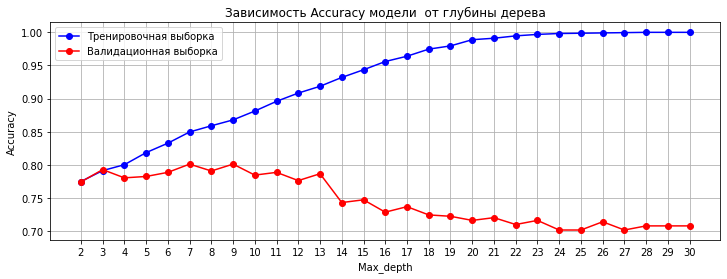

In [16]:
x = depth_list
y = accuracy_valid_tree 
y1 = accuracy_train_tree
plt.figure(figsize=(12, 4))
plt.grid(True)
plt.xticks(x)
plt.plot(x, y1,'-bo')
plt.plot(x, y,'-ro')
plt.legend(['Тренировочная выборка', 'Валидационная выборка'])
plt.xlabel('Max_depth')
plt.ylabel('Accuracy')
plt.title('Зависимость Accuracy модели  от глубины дерева')
plt.show()

Наилучший результат дает глубина в 7 (0.8012422360248447) и 9 с небольшой разницей, поскольку мы хотим избежать излишнего переобучения поэтому остановимся на 7 максимальной глубине дерева.Переобучение на валидационной выборке с глубины 9,далее увелечение глубины резко снижает правильных предсказаний 


[Text(33.0, 0.5, 'Истинные значения'),
 Text(0.5, 15.0, 'Это Ультра:Да-1,Нет-0')]

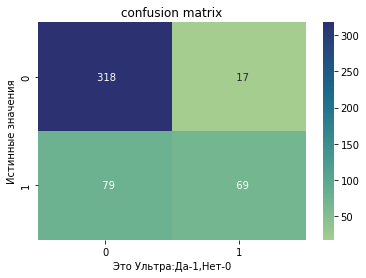

In [17]:
# заполним предсказаниями 
is_ultra = best_tree_model.predict(features_valid)

#построим матрицу предсказаний 
conf_mx = confusion_matrix(target_valid, is_ultra)
ax = sns.heatmap(conf_mx, annot=True, fmt='4.0f', cmap='crest')
plt.title('confusion matrix', size=12)
ax.set(xlabel="Это Ультра:Да-1,Нет-0", ylabel="Истинные значения")

Очень много ложно положительных ответов - 79. Правильно предсказанные 69 для положительных,правильно отрицательные 318 

### Cлучайный лес

Аналогично дереву решений, циклом по гиперпараметрам, только в этом случае двумя.

In [18]:
best_forest_model = None
best_forest_est = 0
best_forest_depth = 0
best_accuracy = 0

#оказывается переобучение не баг, а фича случайного леса, именно поэтому выбрал такие параметры,
# ну еще посмотрел вебинар
# из информации в тренажёре этого нельзя вывести  😒
accuracy_valid_forest_depth = []
forest_n_est = []
for est in range(50, 150,3): 
    forest_n_est.append(est)
    best_result_in_depth =[]
    for depth in range (7,20,1):
        model_forest = RandomForestClassifier(
            random_state=12345, 
            n_estimators=est,
             max_depth=depth,
             n_jobs = -1)
        model_forest.fit(features_train, target_train)
        accuracy = model_forest.score(features_valid, target_valid) 
        if accuracy > best_accuracy:
            best_forest_model = model_forest 
            best_forest_est = est 
            best_forest_depth = depth 
            best_accuracy = accuracy
        best_result_in_depth.append(accuracy)
    accuracy_valid_forest_depth.append(max(best_result_in_depth))
print('Лучшая модель Случайный лес:',best_forest_model)
print('Количество деревьев:', best_forest_est)
print('Глубина дерева лучшей модели:', best_forest_depth)
print('Accuracy лучшей модели:', best_accuracy)

Лучшая модель Случайный лес: RandomForestClassifier(max_depth=17, n_estimators=125, n_jobs=-1,
                       random_state=12345)
Количество деревьев: 125
Глубина дерева лучшей модели: 17
Accuracy лучшей модели: 0.8260869565217391


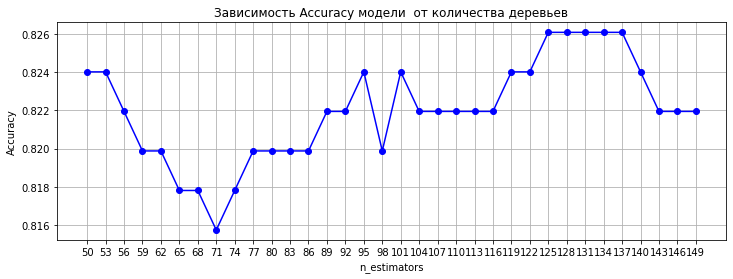

In [19]:
x = forest_n_est
y = accuracy_valid_forest_depth
plt.figure(figsize=(12, 4))
plt.grid(True)
plt.xticks(x)
plt.plot(x, y,'-bo')
#plt.plot(list(range(1,len(accuracy_train_tree)+1)), accuracy_valid_tree,'-ro')
#plt.legend(['Тренировочная выборка', 'Валидационная выборка'])
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Зависимость Accuracy модели  от количества деревьев')
plt.show()

 Как видно из графика, стабильное высокое значение Accuracy достигается уже размере леса в 122,а максимальное с 125 с глубиной 17.Последующие увилечение деревьев не ведет к лучшим предсказаниям,поэтому обучение с большим колличеством деревьев не рационально.
 

[Text(33.0, 0.5, 'Истинные значения'),
 Text(0.5, 15.0, 'Это Ультра:Да-1,Нет-0')]

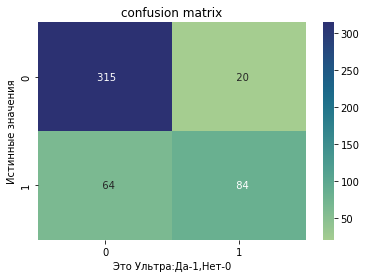

In [20]:
# заполним предсказаниями 
is_ultra = best_forest_model.predict(features_valid)

#построим матрицу предсказаний 
conf_mx = confusion_matrix(target_valid, is_ultra)
ax = sns.heatmap(conf_mx, annot=True, fmt='4.0f', cmap='crest')
plt.title('confusion matrix', size=12)
ax.set(xlabel="Это Ультра:Да-1,Нет-0", ylabel="Истинные значения")

Как видно из тепловой карты,случайный лес угадывает 84 правильных значей являеться ли это тарифом ультра,гораздо лучше предсказывает являеться ли это тарифом смарт,315 истино-отрицательные.Также она ошибаеться в 64 случая, когда предсказывает Смарт как Ультра: ложно-отрицательные. И ложно-положительных:20

### Логическая регрессия


In [21]:
best_result = 0
best_iter = 0
best_model = None 
result_list = []
iter_list=[]
for iter in range(30,1000,10):
    iter_list.append(iter)
    log_reg_model = LogisticRegression(random_state=12345, max_iter=iter) 
    log_reg_model.fit(features_train, target_train) 
    result = log_reg_model.score(features_valid, target_valid) 
    result_list.append(result)
    if result > best_result:
      best_result = result
      best_model = log_reg_model
      best_iter = iter
print("Процент правильных предсказаний модели логистической регрессии:",best_result,'с количеством итераций',best_iter)

Процент правильных предсказаний модели логистической регрессии: 0.7204968944099379 с количеством итераций 30


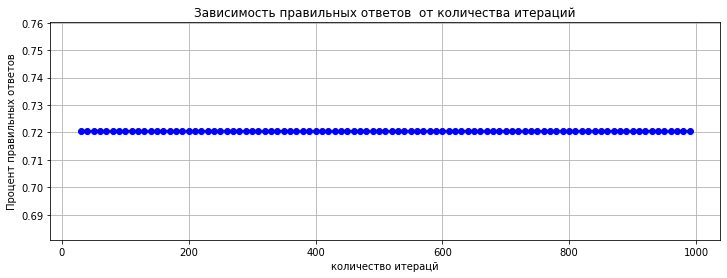

In [22]:
x = iter_list
y = result_list
plt.figure(figsize=(12, 4))
plt.grid(True)

plt.plot(x, y,'-bo')

plt.xlabel('количество итерацй')
plt.ylabel('Процент правильных ответов')
plt.title('Зависимость правильных ответов  от количества итераций')
plt.show()

Видимо значения правильных предсказаний не зависят от колличества итераций 

[Text(33.0, 0.5, 'Истинные значения'),
 Text(0.5, 15.0, 'Это Ультра:Да-1,Нет-0')]

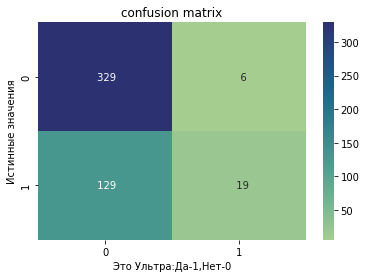

In [23]:
# заполним предсказаниями 
is_ultra = best_model.predict(features_valid)

#построим матрицу предсказаний 
conf_mx = confusion_matrix(target_valid, is_ultra)
ax = sns.heatmap(conf_mx, annot=True, fmt='4.0f', cmap='crest')
plt.title('confusion matrix', size=12)
ax.set(xlabel="Это Ультра:Да-1,Нет-0", ylabel="Истинные значения")

Как видно из тепловой карты,логистическая регрессия угадывает только 19 правильных значей являеться ли это тарифом ультра,гораздо лучше предсказывает являеться ли это тарифом смарт,329 истино-отрицательные.Также она ошибаеться в 129 случая, когда предсказывает Смарт как Ультра: ложно-отрицательные.Гораздо хуже чем случайный лес.Скорее всего связано с разными объемами выборки для Ультра и Смарт


## Проверьте модель на тестовой выборке

Не сложно догадаться,что лучшая модель из рассмотренных нами - является случайный лес.Проверим качество модели на тестовой выборке с лучшими гиппер параметрами.

In [24]:
prediction_test = best_forest_model.predict(features_test)
accuracy_test = accuracy_score(target_test, prediction_test)
print("Доля правильных ответов на тестовой выборке для случайного леса:",accuracy_test)

Доля правильных ответов на тестовой выборке для случайного леса: 0.8091286307053942


[Text(33.0, 0.5, 'Истинные значения'),
 Text(0.5, 15.0, 'Это Ультра:Да-1,Нет-0')]

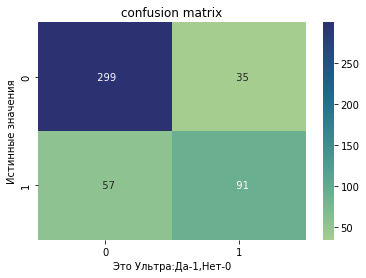

In [25]:
# заполним предсказаниями 
is_ultra = best_forest_model.predict(features_test)

#построим матрицу предсказаний 
conf_mx = confusion_matrix(target_test, is_ultra)
ax = sns.heatmap(conf_mx, annot=True, fmt='4.0f', cmap='crest')
plt.title('confusion matrix', size=12)
ax.set(xlabel="Это Ультра:Да-1,Нет-0", ylabel="Истинные значения")

Истинно-ложных 299,то есть наша модель в на тестовой выборке угадала 299 тарифов Смарт. Истинно положительных 91,а тарифов Ультра только 91.На тестовой выборке больше ошибок в для ложно-положительной 35,против 20 на валидацонной. Есть небольшой эфект переобучения, однако результаты примерно сопоставимы:для тестовой - 0.8091286307053942 и валидацонной - 0.8260869565217391     


<div class="alert alert-success">
<b>✔️ Комментарий ревьюера:</b>

Отлично! 👍

</div>

## (бонус) Проверьте модели на адекватность

Я пытался нагуглить, что такое проверка модели на адекватность. Всегда запрос включал Dummy Classifiers. Насколько я понял, он генерирует случайные предсказания  либо на основе частоты класса, либо 50/50 в зависимости от параметра, при этом игнорирует входные значения. Проверим, насколько наша модель лучше случайности

In [26]:
#частота класса
freq=(df_new['is_ultra'].sum()-df_new['is_ultra'].count())/df_new['is_ultra'].count()
print('Процент самого частого класса "0-Смарт":',-1*freq)

Процент самого частого класса "0-Смарт": 0.693528313627878


In [27]:
dummy_model = DummyClassifier(strategy='most_frequent', random_state=12345) 
dummy_model.fit(features_train, target_train) 
dummy_model.predict(features_test)
dummy_accuracy = dummy_model.score(features_test, target_test)
print('Точность модели на основе самого частого класса:',dummy_accuracy)

Точность модели на основе самого частого класса: 0.6929460580912863


Наша модель дает более точные предсказания на тестовой выборке,чем на основании случайного класса.Разве это не прекрасно ?:) 

## Чек-лист готовности проекта

## Вывод:

Было проведено исследование на лучшую модель, предсказывающую какой тариф выберет клиент Смарт или Ультра. На основании входных параметров: 'minutes', 'messages', 'mb_used', 'is_ultra'.
Тестировались три модели:
* Дерево решений
* Случайный лес  
* Логистическая регрессия.
  
Дерево решений предсказывало с точностью  80% процентов при глубине дерева = 7.Поскольку очень большой риск переобучения, мы воспользовались Случайным лесом, он давал 83% на валидационной выборке и 80% на тестовой при количестве деревьев 125,а глубине 17.Одна голова хорошо, а 125 лучше. И использовали логистическую регрессию. Ее точность составляла 73%,что суть лучше, чем на основе частоты класса. 
Задача добиться точности больше 75% на тестовой выборке выполнена  с помощью модели Случайного Леса.
